In [1]:
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.manifold import TSNE
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.metrics import r2_score

In [2]:
def get_year(x):
    if pd.isna(x):
        return 0
    else:
        return(int(x[-4:]))

users = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', sep='|',
                 names=['user_id','age','gender','occupation','zip_code'])
users = users.drop(['zip_code'],axis=1)


data = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                 names=['user_id','movie_id','rating','tstamp']).sample(frac=1)
data['date'] = pd.to_datetime(data['tstamp'],unit='s')
data['liked'] = (data['rating'] >= 3).astype(int)
data = data.drop(['tstamp'],axis=1)

movies = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|',
                    names=['movie_id' ,'movie title' ,'release date' ,'video release date' ,
                           'IMDb URL' ,'unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western'],encoding='latin')

movies['year'] = movies['release date'].apply(get_year)
movies = movies.drop(['release date','video release date','IMDb URL'],axis=1)

movies = movies.set_index('movie_id')
users = users.set_index('user_id')
num_users = len(pd.unique(data['user_id']))
num_movie = len(pd.unique(data['movie_id']))
data_joined = data.join(movies,on='movie_id',how='inner').join(users,on='user_id',how='inner')
print(data_joined.head())
print(data_joined.dtypes)

       user_id  movie_id  rating                date  liked  \
87910      765       151       4 1997-11-24 04:36:44      1   
55803      765       127       5 1997-11-24 04:45:22      1   
81607      765        10       4 1997-11-24 04:38:28      1   
59268      765       286       5 1997-11-24 04:31:02      1   
72358      765       222       2 1997-11-24 04:39:00      0   

                                        movie title  unknown  Action  \
87910  Willy Wonka and the Chocolate Factory (1971)        0       0   
55803                         Godfather, The (1972)        0       1   
81607                            Richard III (1995)        0       0   
59268                   English Patient, The (1996)        0       0   
72358               Star Trek: First Contact (1996)        0       1   

       Adventure  Animation  ...  Mystery  Romance  Sci-Fi  Thriller  War  \
87910          1          0  ...        0        0       0         0    0   
55803          0          0  ...  

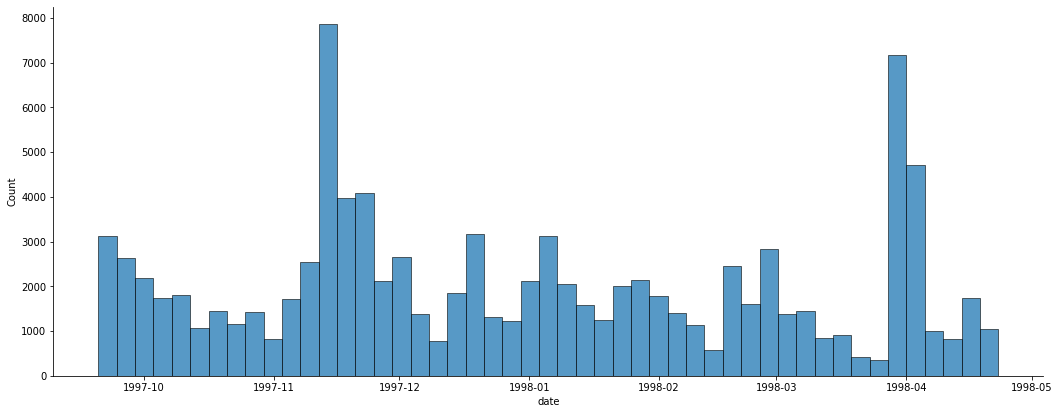

In [3]:
g = sns.displot(data_joined['date'])
g.fig.set_figheight(6)
g.fig.set_figwidth(18)

In [4]:
#Date based split and Shuffle them. I thought it was already shuffled when I loaded it from CSV.
#But its not. So shuffle is important here
cutoff_date = '1998-03-01'
df_train = data_joined[data_joined['date'] < cutoff_date].sample(frac=1)
df_test = data_joined[data_joined['date'] >= cutoff_date].sample(frac=1)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

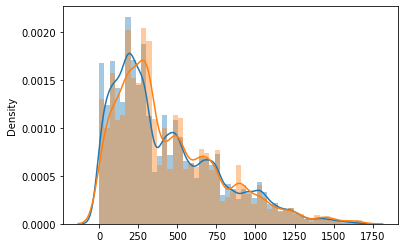

In [5]:
X_train = df_train[['user_id','movie_id']].to_numpy() - 1
y_train = df_train['rating'].to_numpy()
X_test = df_test[['user_id','movie_id']].to_numpy() - 1
y_test = df_test['rating'].to_numpy()

sns.distplot(X_train[:,1])
sns.distplot(X_test[:,1])

In [6]:
print(len(np.unique(X_train[:,0])), len(np.unique(X_test[:,0])))
print(len(pd.unique(data['user_id'])))
print(len(np.unique(X_train[:,1])), len(np.unique(X_test[:,1])))
print(len(pd.unique(data['movie_id'])))

736 327
943
1608 1467
1682


In [7]:
def collaborative_model(num_users, num_movies, emb_dim):
    x = tf.keras.Input((2))
    x_user = tf.keras.layers.Embedding(num_users,emb_dim,
#                                        embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='users')(x[:,0])
    x_movie = tf.keras.layers.Embedding(num_movies,emb_dim,
#                                        embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='movies')(x[:,1])
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x, outputs=out, name="colab_model")


In [8]:
model = collaborative_model(num_users,num_movie,64)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=4,
    restore_best_weights=True
)])    
    
umat = model.get_layer('users').get_weights()[0]
mmat = model.get_layer('movies').get_weights()[0]

2022-10-15 21:14:59.601327: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-15 21:14:59.773344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
2194/2194 [==============================] - 7s 3ms/step - loss: 7.0038 - mse: 7.0020 - val_loss: 1.3287 - val_mse: 1.3289
Epoch 2/40
2194/2194 [==============================] - 7s 3ms/step - loss: 1.0483 - mse: 1.0483 - val_loss: 0.9696 - val_mse: 0.9699
Epoch 3/40
2194/2194 [==============================] - 6s 3ms/step - loss: 0.8991 - mse: 0.8991 - val_loss: 0.9207 - val_mse: 0.9210
Epoch 4/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.8325 - mse: 0.8325 - val_loss: 0.8769 - val_mse: 0.8775
Epoch 5/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.7689 - mse: 0.7688 - val_loss: 0.8632 - val_mse: 0.8638
Epoch 6/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.7043 - mse: 0.7046 - val_loss: 0.8563 - val_mse: 0.8567
Epoch 7/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.6387 - mse: 0.6386 - val_loss: 0.8533 - val_mse: 0.8536
Epoch 8/40
2194/2194 [==============================] - 7s 3ms

In [13]:
#Experiment - how new datapoints including unseen users and movies interact (cold start problem)
#holdout set
unseen_indices = ~(np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id']))
X_test_unseen = X_test[unseen_indices]
y_test_unseen = y_test[unseen_indices]
print(X_test_unseen.shape,y_test_unseen.shape,X_test.shape)
y_pred = model(X_test_unseen)
tf.keras.metrics.mean_squared_error(y_test_unseen, y_pred)
r2_score(y_test_unseen, y_pred)

(18300, 2) (18300,) (22015, 2)


-10.111158296702097

In [14]:
#Experiment - how new datapoints including seen users and movies interact
seen_indices =    np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id'])
X_test_seen = X_test[seen_indices]
y_test_seen = y_test[seen_indices]
print(X_test_seen.shape,y_test_seen.shape,X_test.shape)
y_pred = model(X_test_seen)
tf.keras.metrics.mean_squared_error(y_test_seen, y_pred)
r2_score(y_test_seen, y_pred)

(3715, 2) (3715,) (22015, 2)


0.2284724765054591

In [16]:
#TSNE for visualization
tsne = TSNE()
# users = tsne.fit_transform(model.get_layer('users').get_weights()[0])
movies_embeddings = tsne.fit_transform(model.get_layer('movies').get_weights()[0])
new_df = pd.DataFrame(movies_embeddings)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



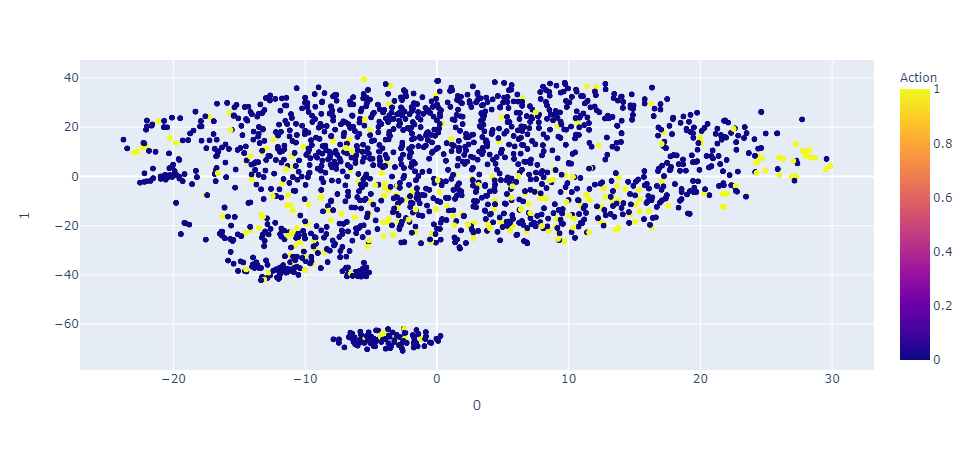

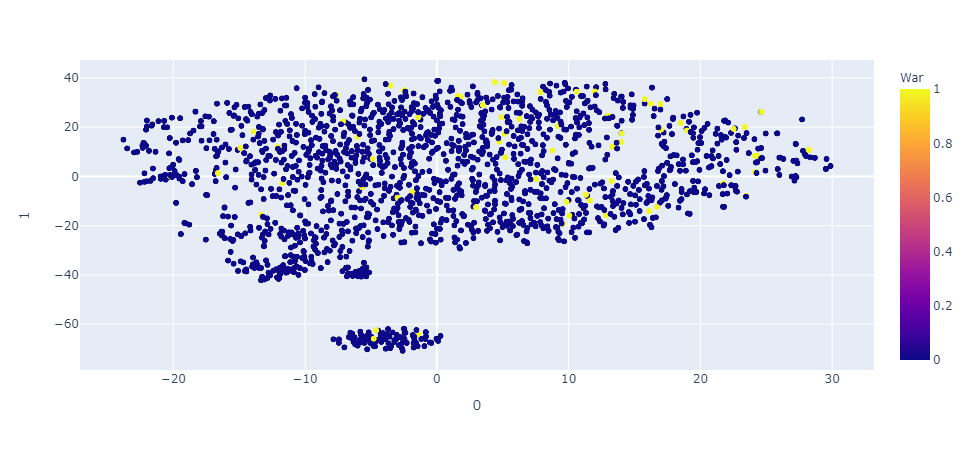

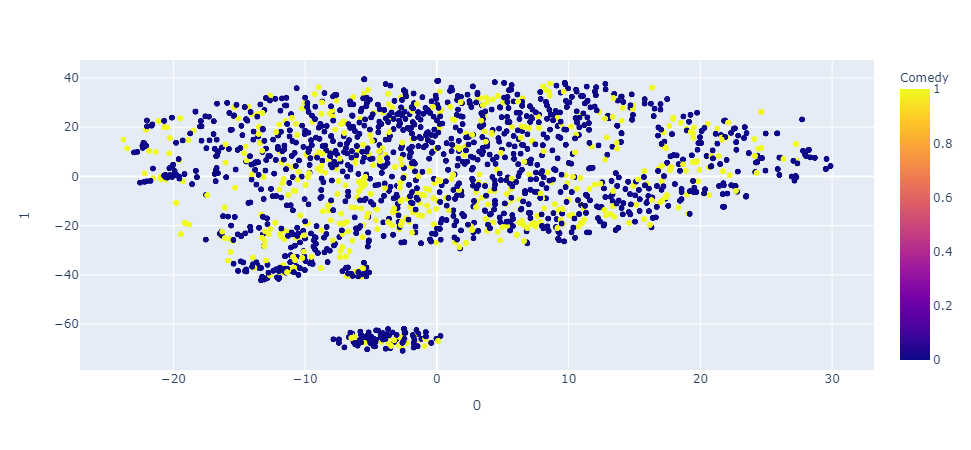

In [17]:
new_df[2] = movies['movie title'].to_numpy()
new_df.set_index(np.array(new_df.index)+1, inplace = True)
# new_df[3] = items.drop(columns=[0,1,2,3,4]).idxmax(axis=1)
new_df = pd.concat([new_df,movies[['unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western']]],axis=1)
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='Action')
fig.show()
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='War')
fig.show()
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='Comedy')
fig.show()

In [40]:
def pairwise_cosine_distance(x):
    #  x.shape = (samples,features)
    # cosine_distance_matrix.shape = (smaples,samples)
    dot = np.matmul(x,x.T)
    norms = np.linalg.norm(x,axis=1)
    cosine_distance_mat = 1 - dot/(norms[...,np.newaxis] * norms[np.newaxis,...])
    return cosine_distance_mat

class Movie_similarity():
    def __init__(self,criteria,embeddings):
        self.sim_mat = criteria(embeddings)
        
    def get_k_similar_movies_indices(self,index,k):
        sorted_index_mat = np.argsort(self.sim_mat,axis=1)
        return(sorted_index_mat[index,:k])
    
similarities = Movie_similarity(pairwise_cosine_distance,movies_embeddings)        

In [71]:
movie_name = 'copycat'
index = movies[movies['movie title'].str.lower().str.contains(movie_name)].index[0]-1
movies['movie title'].iloc[similarities.get_k_similar_movies_indices(index=index,k=10)]

movie_id
5                          Copycat (1995)
125                     Phenomenon (1996)
729                           Nell (1994)
270                        Gattaca (1997)
282                Time to Kill, A (1996)
625        Sword in the Stone, The (1963)
827                       Daylight (1996)
951    Indian in the Cupboard, The (1995)
255       My Best Friend's Wedding (1997)
939            Murder in the First (1995)
Name: movie title, dtype: object

In [69]:
movies

,movie title,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,GoldenEye (1995),0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,Four Rooms (1995),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
4,Get Shorty (1995),0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
5,Copycat (1995),0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,Mat' i syn (1997),0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1998
1679,B. Monkey (1998),0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998
1680,Sliding Doors (1998),0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1998


In [35]:
#train
ohe = OHE(handle_unknown='ignore',sparse=False)
X_train = np.concatenate([df_train.drop(['date','movie_id','liked',
                                           'user_id','movie title',
                                           'rating','gender','occupation'],axis=1),
                         ohe.fit_transform(df_train[['gender','occupation']])],axis=1)

#test
X_test = np.concatenate([df_test.drop(['date','movie_id','liked',
                                           'user_id','movie title',
                                           'rating','gender','occupation'],axis=1),
                         ohe.fit_transform(df_test[['gender','occupation']])],axis=1)
print(X_train.shape)

(77985, 44)


In [30]:
def neural_embeddings_collaborative_model(data_dimension, user_data_start_index,emb_dim,drop_out=0.2):
    x_data = tf.keras.Input((data_dimension))
    x_movie_in = x_data[:,:user_data_start_index]
    x_user_in = x_data[:,user_data_start_index:]
    drop_out_layer = tf.keras.layers.Dropout(drop_out)
    x_user = drop_out_layer(tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_user_in))
    x_user = drop_out_layer(tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_user))
    x_user = tf.keras.layers.Dense(emb_dim,activation='relu')(x_user)
    x_movie = drop_out_layer(tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_movie_in))
    x_movie = drop_out_layer(tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_movie))
    x_movie = tf.keras.layers.Dense(emb_dim,activation='relu')(x_movie)
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x_data, outputs=out, name="neural_embeddings_collaborative_model")

In [ ]:
#Network does not seem to converge. Either too much randomness in the data or the network is not stong
#enough. Its as good at learning embeddings as initializing them randomly.

model = neural_embeddings_collaborative_model(X_train.shape[1],20,64)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=60,
    restore_best_weights=True
)])    

In [ ]:
#Experiment - how new datapoints including unseen users and movies interact (cold start problem)
#holdout set 

unseen_indices = ~(np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id']))
X_test_unseen = X_test[unseen_indices]
y_test_unseen = y_test[unseen_indices]
print(X_test_unseen.shape,y_test_unseen.shape,X_test.shape)
y_pred = model(X_test_unseen)
tf.keras.metrics.mean_squared_error(y_test_unseen, y_pred)

In [ ]:
#Experiment - how new datapoints including seen users and movies interact
seen_indices = np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id'])
X_test_seen = X_test[seen_indices]
y_test_seen = y_test[seen_indices]
print(X_test_seen.shape,y_test_seen.shape,X_test.shape)
y_pred = model(X_test_seen)
tf.keras.metrics.mean_squared_error(y_test_seen, y_pred)

In [ ]:
# simple model which simply spits out average rating for the movie. Assumes all users are average. Performs
#better than the neural net above
y_pred = []
avg_rating = df_train.groupby('movie_id').mean()
for movie_id in df_test['movie_id']:
    rating = avg_rating[avg_rating.index == movie_id]['rating'].to_numpy()
    if len(rating):
        y_pred.append(rating[0])
    else:
        y_pred.append(3)
        
r2_score(y_test,y_pred)

In [20]:
#changing the problem to a classification

X_train = df_train[['user_id','movie_id']].to_numpy() - 1
y_train = df_train['liked'].to_numpy()
X_test = df_test[['user_id','movie_id']].to_numpy() - 1
y_test = df_test['liked'].to_numpy()


In [21]:
model = collaborative_model(num_users,num_movie,64)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),)
#     metrics=['accuracy'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)])    
    
umat = model.get_layer('users').get_weights()[0]
mmat = model.get_layer('movies').get_weights()[0]

Epoch 1/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.5527 - val_loss: 0.3883
Epoch 2/40
2194/2194 [==============================] - 6s 3ms/step - loss: 0.3676 - val_loss: 0.3666
Epoch 3/40
2194/2194 [==============================] - 6s 3ms/step - loss: 0.3337 - val_loss: 0.3573
Epoch 4/40
2194/2194 [==============================] - 6s 3ms/step - loss: 0.3008 - val_loss: 0.3553
Epoch 5/40
2194/2194 [==============================] - 6s 3ms/step - loss: 0.2661 - val_loss: 0.3557
Epoch 6/40
2194/2194 [==============================] - 6s 3ms/step - loss: 0.2289 - val_loss: 0.3602
Epoch 7/40
2194/2194 [==============================] - 6s 3ms/step - loss: 0.1915 - val_loss: 0.3696
Epoch 8/40
2194/2194 [==============================] - 6s 3ms/step - loss: 0.1558 - val_loss: 0.3831


In [37]:
#Experiment - how new datapoints including unseen users and movies interact (cold start problem)
#holdout set
unseen_indices = ~(np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id']))
X_test_unseen = X_test[unseen_indices]
y_test_unseen = y_test[unseen_indices]
print(X_test_unseen.shape,y_test_unseen.shape,X_test.shape)
acc = tf.keras.metrics.Accuracy()
y_pred = tf.cast(model(X_test_unseen)>0 , tf.int32)
acc(y_pred,y_test_unseen)

(18300, 44) (18300,) (22015, 44)


<tf.Tensor: shape=(), dtype=float32, numpy=0.17027323>

In [38]:
#Experiment - how new datapoints including seen users and movies interact
seen_indices = np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id'])
X_test_seen = X_test[seen_indices]
y_test_seen = y_test[seen_indices]
print(X_test_seen.shape,y_test_seen.shape,X_test.shape)
acc = tf.keras.metrics.Accuracy()
y_pred = tf.cast(model(X_test_seen)>0 , tf.int32)
acc(y_pred,y_test_seen)

(3715, 44) (3715,) (22015, 44)


<tf.Tensor: shape=(), dtype=float32, numpy=0.17388964>

In [36]:
model = neural_embeddings_collaborative_model(X_train.shape[1],20,64)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),)
#     metrics=['mse'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)])  

Epoch 1/40
2194/2194 [==============================] - 12s 5ms/step - loss: 1.5753 - val_loss: 0.6931
Epoch 2/40
2194/2194 [==============================] - 11s 5ms/step - loss: 0.7015 - val_loss: 0.6931
Epoch 3/40
2194/2194 [==============================] - 11s 5ms/step - loss: 0.7129 - val_loss: 0.6931
Epoch 4/40
2194/2194 [==============================] - 11s 5ms/step - loss: 0.7149 - val_loss: 0.6931
Epoch 5/40
2194/2194 [==============================] - 11s 5ms/step - loss: 0.7096 - val_loss: 0.6931
Epoch 6/40
2194/2194 [==============================] - 12s 5ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/40
2194/2194 [==============================] - 13s 6ms/step - loss: 0.7031 - val_loss: 0.6931


In [34]:
X_train.shape

(77985, 45)